In [2]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [3]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 2e-3
NUM_CLASSES = 15

# 1. Loading and Processing Data

In [4]:
# TRAIN_PATH='/kaggle/input/traffic-signs/dataset/dataset/train'
# VAL_PATH='/kaggle/input/traffic-signs/dataset/dataset/val'
# TEST_PATH='/kaggle/input/traffic-signs/dataset/dataset/test'
# CLASS_MAPPING_PATH='/kaggle/input/traffic-signs/class_mapping.txt'
TRAIN_PATH='../dataset/classification/train'
VAL_PATH='../dataset/classification/val'
TEST_PATH='../dataset/classification/test'
CLASS_MAPPING_PATH='../dataset/classification/class_mapping.txt'

In [5]:
# Hàm đọc class mapping từ file txt
def load_class_mapping(txt_path):
    idx_to_class = {}
    with open(txt_path, 'r') as f:
        for line in f:
            idx, class_name = line.strip().split(':')
            idx_to_class[int(idx)] = class_name.strip()
    return idx_to_class

# Load mapping
idx_to_class = load_class_mapping(CLASS_MAPPING_PATH)
class_to_idx = {v: k for k, v in idx_to_class.items()}  # Đảo ngược để có class_to_idx

In [6]:
class_to_idx

{'speed limit 20': 0,
 'speed limit 30': 1,
 'speed limit 50': 2,
 'speed limit 60': 3,
 'speed limit 70': 4,
 'speed limit 80': 5,
 'no entry for all vehicles': 6,
 'speed limit 100': 7,
 'speed limit 120': 8,
 'no passing': 9,
 'no truck passing': 10,
 'no parking': 11,
 'no horn': 12,
 'no entry in this direction': 13,
 'no cars': 14}

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets

# Pipeline augmentation cho tập train
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Affine(scale=(0.8, 1.2)),      # Co giãn ảnh (giúp mô phỏng mũi tên "mỏng" hơn)
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5
    ),                               # Dịch chuyển + xoay
    A.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02
    ),                               # Thay đổi màu
    A.CoarseDropout(
        max_holes=8, max_height=20, max_width=20, p=0.3
    ),                               # Giả lập vật che khuất
    A.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()                     # Chuyển sang tensor
])

# Pipeline cho validation/test
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Pipeline cho test
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1944\3514238614.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [9]:
# Load dataset
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=test_transform)

In [10]:
# Ghi đè class names bằng mapping từ file
train_dataset.classes = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
train_dataset.class_to_idx = {cls: i for i, cls in enumerate(train_dataset.classes)}

# Ghi đè class names bằng mapping từ file
val_dataset.classes = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
val_dataset.class_to_idx = {cls: i for i, cls in enumerate(val_dataset.classes)}

# Ghi đè class names bằng mapping từ file
test_dataset.classes = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
test_dataset.class_to_idx = {cls: i for i, cls in enumerate(test_dataset.classes)}

# Tạo DataLoader (giữ nguyên)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Model

In [11]:
model = models.resnet50(pretrained=True)

# Đóng băng tất cả trừ layer3, layer4 và fc
for name, param in model.named_parameters():
    if "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Thay đổi lớp FC cuối cho 15 lớp
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Chuyển model sang GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [11]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Lists để lưu metrics
epochs_list = []
train_loss_list = []
val_loss_list = []
accuracy_list = []
precision_list = []
recall_list = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    # === Training Phase với Progress Bar ===
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)  # Thay leave=False thành leave=True
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_loop.set_postfix(loss=loss.item())  # Hiển thị loss hiện tại
    
    # === Validation Phase với Progress Bar ===
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=True)  # Thay leave=False thành leave=True
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_loop.set_postfix(val_loss=loss.item())  # Hiển thị val_loss hiện tại
    
    # === Tính toán metrics ===
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    # Lưu metrics
    epochs_list.append(epoch + 1)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    
    # In thông tin epoch
    print(f"\nEpoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Accuracy: {accuracy:.4f} | "
          f"Precision: {precision:.4f} | "
          f"Recall: {recall:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 352/352 [01:25<00:00,  4.09it/s, val_loss=2.45]



Epoch 1/10 | Train Loss: 1.1965 | Val Loss: 0.8497 | Accuracy: 0.7169 | Precision: 0.7465 | Recall: 0.7169


Epoch 2/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.40it/s, val_loss=1.57]



Epoch 2/10 | Train Loss: 0.9799 | Val Loss: 0.7559 | Accuracy: 0.7406 | Precision: 0.7720 | Recall: 0.7406


Epoch 3/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.40it/s, val_loss=2.08]



Epoch 3/10 | Train Loss: 0.9243 | Val Loss: 0.7191 | Accuracy: 0.7547 | Precision: 0.7889 | Recall: 0.7547


Epoch 4/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.36it/s, val_loss=1.89]



Epoch 4/10 | Train Loss: 0.9020 | Val Loss: 0.7023 | Accuracy: 0.7634 | Precision: 0.7947 | Recall: 0.7634


Epoch 5/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.36it/s, val_loss=2.06]



Epoch 5/10 | Train Loss: 0.8721 | Val Loss: 0.6602 | Accuracy: 0.7764 | Precision: 0.7917 | Recall: 0.7764


Epoch 6/10 [Val]: 100%|██████████| 352/352 [00:56<00:00,  6.27it/s, val_loss=1.95]



Epoch 6/10 | Train Loss: 0.8617 | Val Loss: 0.6231 | Accuracy: 0.7859 | Precision: 0.8126 | Recall: 0.7859


Epoch 7/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.38it/s, val_loss=1.25]



Epoch 7/10 | Train Loss: 0.8494 | Val Loss: 0.7129 | Accuracy: 0.7591 | Precision: 0.8006 | Recall: 0.7591


Epoch 8/10 [Val]: 100%|██████████| 352/352 [00:54<00:00,  6.44it/s, val_loss=2.09]



Epoch 8/10 | Train Loss: 0.8344 | Val Loss: 0.6380 | Accuracy: 0.7807 | Precision: 0.7914 | Recall: 0.7807


Epoch 9/10 [Val]: 100%|██████████| 352/352 [00:58<00:00,  5.98it/s, val_loss=1.8]



Epoch 9/10 | Train Loss: 0.8187 | Val Loss: 0.5957 | Accuracy: 0.7954 | Precision: 0.8132 | Recall: 0.7954


Epoch 10/10 [Val]: 100%|██████████| 352/352 [00:55<00:00,  6.37it/s, val_loss=1.71]


Epoch 10/10 | Train Loss: 0.8045 | Val Loss: 0.5917 | Accuracy: 0.8003 | Precision: 0.8236 | Recall: 0.8003


In [12]:
torch.save(model.state_dict(), "resnet50_model_v01.pth")    

# 3. Evaluation

In [13]:
# Lấy danh sách tên lớp từ idx_to_class (đã load từ file mapping)
class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]

# Ví dụ output:
# ['speed_limit_20', 'speed_limit_30', ..., 'stop']

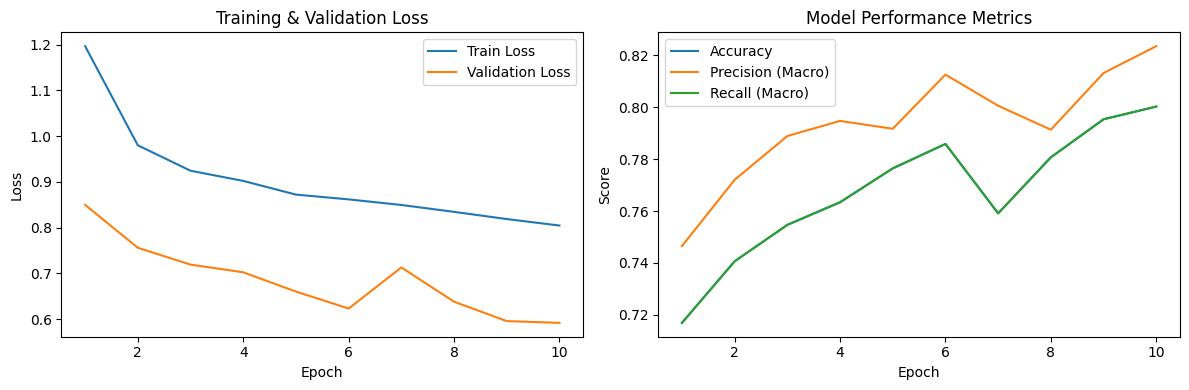

In [14]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Train Loss')
plt.plot(epochs_list, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Metrics
plt.subplot(1, 2, 2)
plt.plot(epochs_list, accuracy_list, label='Accuracy')
plt.plot(epochs_list, precision_list, label='Precision (Macro)')
plt.plot(epochs_list, recall_list, label='Recall (Macro)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
metrics_df = pd.DataFrame({
    'Epoch': epochs_list,
    'Train Loss': train_loss_list,
    'Val Loss': val_loss_list,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list
})

metrics_df.to_csv('training_metrics_v01.csv', index=False)

In [16]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating Test Set',leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Gọi hàm đánh giá
test_labels, test_preds = evaluate_model(model, test_loader, device)

# In báo cáo classification
print("\nTest Set Evaluation:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Evaluating Test Set: 100%|██████████| 352/352 [01:55<00:00,  3.05it/s]


Test Set Evaluation:
                            precision    recall  f1-score   support

            speed limit 20       0.93      0.82      0.87       750
            speed limit 30       0.86      0.43      0.57       750
            speed limit 50       0.92      0.83      0.87       750
            speed limit 60       1.00      0.98      0.99       750
            speed limit 70       0.99      0.95      0.97       750
            speed limit 80       0.99      0.98      0.98       750
 no entry for all vehicles       0.90      1.00      0.95       750
           speed limit 100       0.49      0.79      0.60       750
           speed limit 120       0.71      0.56      0.63       750
                no passing       0.84      0.54      0.65       750
          no truck passing       0.58      0.72      0.64       750
                no parking       0.99      0.98      0.98       750
                   no horn       0.84      0.82      0.83       750
no entry in this directio

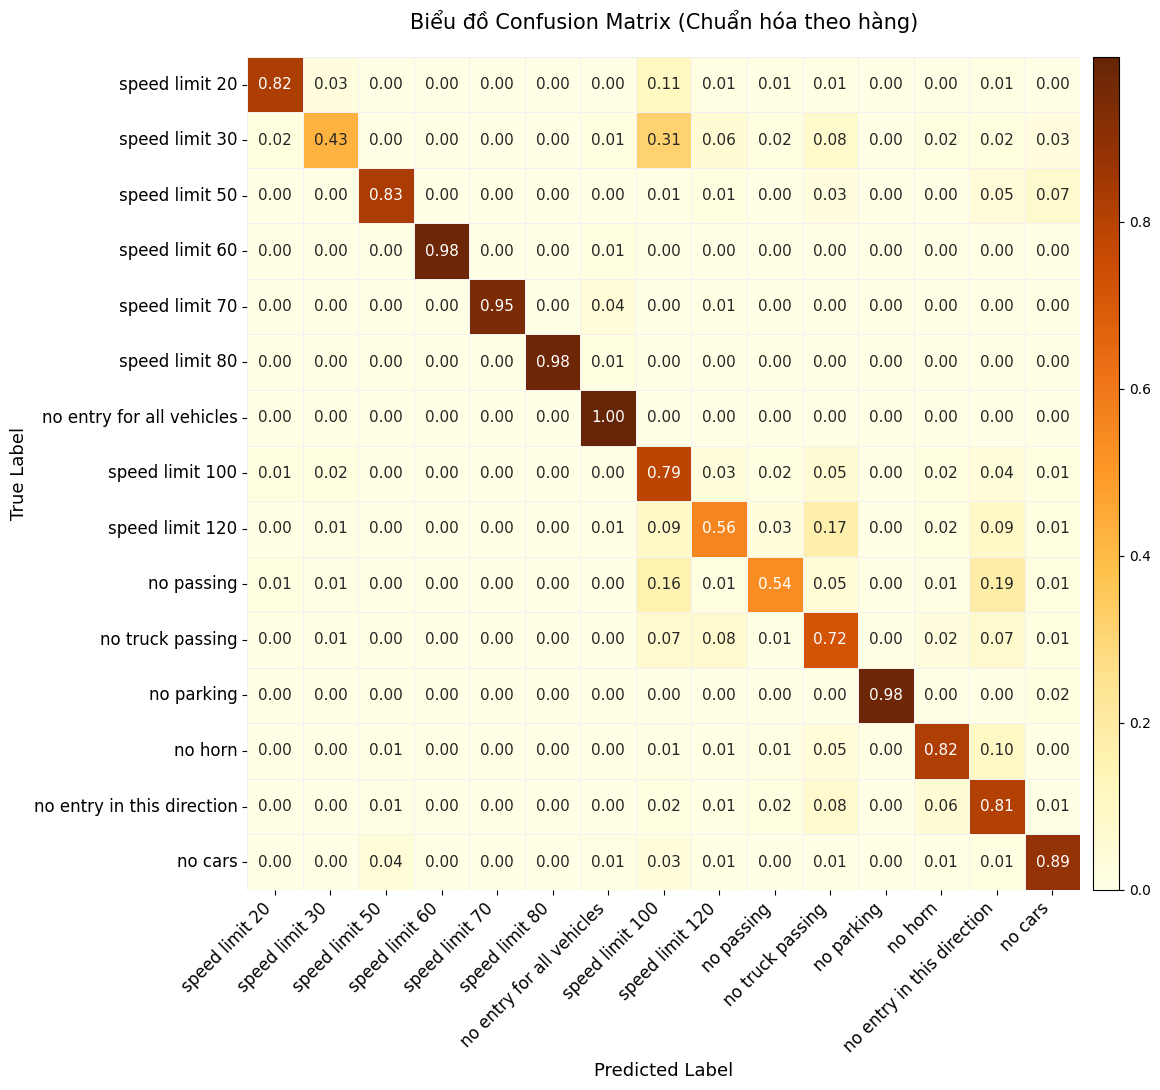

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap='Blues', figsize=(12, 10), fontsize=12):
    """
    Vẽ confusion matrix được định dạng đẹp mắt.
    
    Parameters:
    y_true (array): Nhãn thực tế
    y_pred (array): Nhãn dự đoán
    classes (list): Danh sách tên các lớp
    normalize (bool): Có chuẩn hóa theo hàng hay không
    title (str): Tiêu đề đồ thị
    cmap (str): Bảng màu
    figsize (tuple): Kích thước figure
    fontsize (int): Cỡ chữ
    """
    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Chuẩn hóa nếu được yêu cầu
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # Tạo figure
    plt.figure(figsize=figsize, dpi=100)
    
    # Tạo heatmap
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        cbar=False,
        square=True,
        annot_kws={'size': fontsize-2},
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # Thiết lập tiêu đề
    if title is None:
        title = 'Normalized Confusion Matrix' if normalize else 'Confusion Matrix'
    ax.set_title(title, fontsize=fontsize+2, pad=20)
    
    # Thiết lập nhãn trục
    ax.set_xlabel('Predicted Label', fontsize=fontsize)
    ax.set_ylabel('True Label', fontsize=fontsize)
    
    # Thiết lập tick labels
    tick_marks = np.arange(len(classes)) + 0.5
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=fontsize-1)
    ax.set_yticklabels(classes, rotation=0, fontsize=fontsize-1)
    
    # Điều chỉnh layout
    plt.tight_layout()
    
    # Thêm colorbar riêng để kiểm soát tốt hơn
    cax = plt.gcf().add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(ax.collections[0], cax=cax)
    
    # Hiển thị grid nhẹ
    ax.grid(False)
    ax.hlines(y=np.arange(len(classes)+1), xmin=0, xmax=len(classes), colors='white', linewidths=0.5)
    ax.vlines(x=np.arange(len(classes)+1), ymin=0, ymax=len(classes), colors='white', linewidths=0.5)

# Sử dụng
plot_confusion_matrix(
    test_labels, 
    test_preds, 
    classes=class_names, 
    normalize=True,
    title='Biểu đồ Confusion Matrix (Chuẩn hóa theo hàng)',
    cmap='YlOrBr',
    figsize=(13, 11),
    fontsize=13
)
plt.show()